In [307]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression,classification, Pipeline, evaluation
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

In [347]:
df = pd.read_csv('AB_NYC_2019.csv')

In [348]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [349]:
df.drop(['id',"host_id","name",'host_name','last_review',"latitude",'longitude'], axis=1, inplace=True)

In [350]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [351]:
a = df['neighbourhood'].value_counts()

In [352]:
m = df['neighbourhood'].isin(a.index[a<400])

In [353]:
df.loc[m, 'neighbourhood'] = "Others"

In [354]:
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [355]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [356]:
df=df[df["price"]<500]

In [357]:
#df['neighbourhood_group'] = df['neighbourhood_group'].map({'Brooklyn': 0, 'Manhattan': 1, 'Queens': 2,'Staten Island': 3, 'Bronx':4})

In [358]:
df

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Others,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,0.40,1,0
7,Manhattan,Hell's Kitchen,Private room,79,2,430,3.47,1,220
8,Manhattan,Upper West Side,Private room,79,2,118,0.99,1,0
9,Manhattan,Others,Entire home/apt,150,1,160,1.33,4,188


In [359]:
df.to_csv("cleanbnb.csv")

In [360]:
spark_df = spark.read.csv('cleanbnb.csv', header=True, inferSchema=True)

Index(['name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

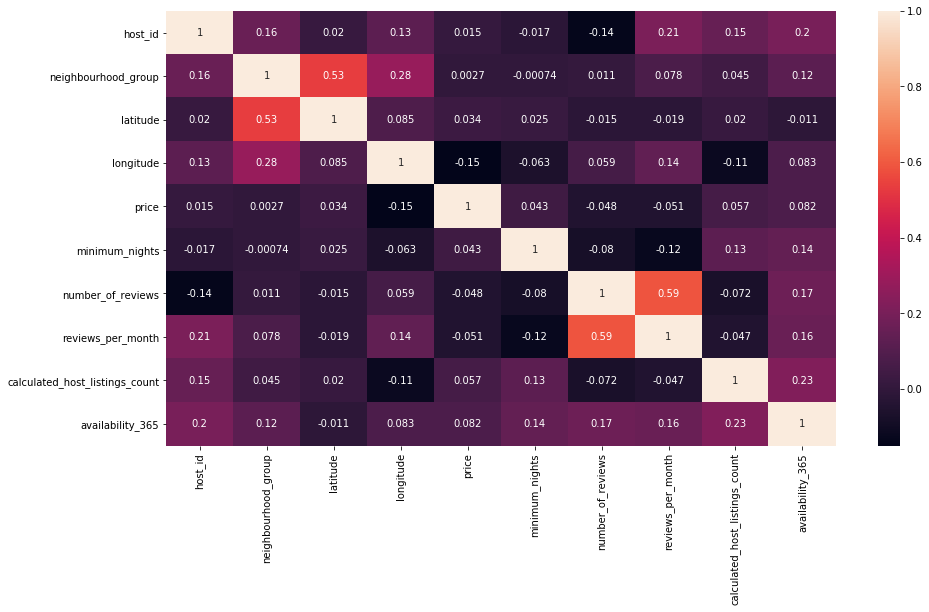

In [22]:
corr = df.corr(method='pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns

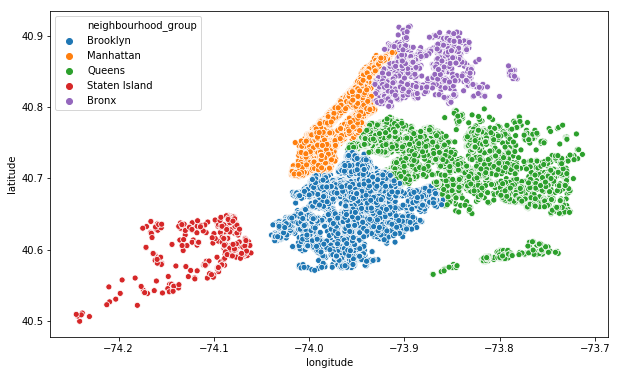

In [12]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group)
plt.ioff()

In [254]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [271]:
df=df[df["price"]<500]

In [274]:
df[df["price"]<500]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Others,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129
6,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0
7,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,3.47,1,220
8,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,0.99,1,0
9,Manhattan,Others,40.71344,-73.99037,Entire home/apt,150,1,160,1.33,4,188


In [26]:
df.drop(['neighbourhood_group'], axis=1, inplace=True)

In [289]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [361]:
spark_df = spark_df.withColumn("calculated_host_listings_count", spark_df["calculated_host_listings_count"].cast("double"))
spark_df = spark_df.withColumn("minimum_nights", spark_df["minimum_nights"].cast("double"))
spark_df = spark_df.withColumn("price", spark_df["price"].cast("double"))
spark_df = spark_df.withColumn("number_of_reviews", spark_df["number_of_reviews"].cast("double"))
spark_df = spark_df.withColumn("price", spark_df["price"].cast("double"))
spark_df = spark_df.withColumn("availability_365", spark_df["availability_365"].cast("double"))


In [362]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: double (nullable = true)



In [363]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

va = VectorAssembler(inputCols= ["neighbourhood_feat",'neighbourhood_group_feat',"room_type_feat",'minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365'],outputCol="features" )
sd = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
pipe = Pipeline(stages= [StringIndexer(inputCol="neighbourhood", outputCol="neighbourhoodindex", stringOrderType='frequencyDesc'),
                         StringIndexer(inputCol="neighbourhood_group", outputCol="neighbourhood_groupindex",stringOrderType='frequencyDesc'),
                         StringIndexer(inputCol="room_type", outputCol="room_typeindex",stringOrderType='frequencyDesc'),
                        OneHotEncoder(inputCol="neighbourhoodindex", outputCol="neighbourhood_feat", dropLast = False),
                         OneHotEncoder(inputCol="neighbourhood_groupindex", outputCol="neighbourhood_group_feat", dropLast = False),
                        OneHotEncoder(inputCol="room_typeindex", outputCol="room_type_feat", dropLast = False),va,sd]).fit(spark_df)


In [364]:
d=pipe.transform(spark_df)

In [365]:
d.show()

+---+-------------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+------------------+------------------------+--------------+------------------+------------------------+--------------+--------------------+--------------------+
|_c0|neighbourhood_group|     neighbourhood|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|neighbourhoodindex|neighbourhood_groupindex|room_typeindex|neighbourhood_feat|neighbourhood_group_feat|room_type_feat|            features|      scaledFeatures|
+---+-------------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+------------------+------------------------+--------------+------------------+------------------------+--------------+--------------------+--------------------+
|  0|           Brookl

In [366]:
training_df, validation_df, testing_df = spark_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [367]:
from pyspark.ml.regression import RandomForestRegressor
pipe_rf1 = Pipeline(stages=[pipe, RandomForestRegressor(labelCol='price', featuresCol='scaledFeatures',maxDepth=1, numTrees=60)]).fit(training_df)
pipe_rf2 = Pipeline(stages=[pipe, RandomForestRegressor(labelCol='price', featuresCol='scaledFeatures',maxDepth=3, numTrees=40)]).fit(training_df)
pipe_rf3 = Pipeline(stages=[pipe, RandomForestRegressor(labelCol='price', featuresCol='scaledFeatures',maxDepth=6, numTrees=20)]).fit(training_df)


In [368]:
evaluator = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

In [369]:
print(evaluator.evaluate(pipe_rf1.transform(validation_df))) 
print(evaluator.evaluate(pipe_rf2.transform(validation_df)))
print(evaluator.evaluate(pipe_rf3.transform(validation_df)))

71.55745125705758
65.7207885074504
62.51297007998151


In [370]:
pipe_lr = Pipeline(stages=[pipe, regression.LinearRegression(featuresCol='scaledFeatures',labelCol='price')]).fit(training_df)


In [371]:
print(evaluator.evaluate(pipe_lr.transform(validation_df))) 


62.833475382788585


In [372]:
pipe_lr.transform(validation_df).select("price","prediction").show()

+-----+------------------+
|price|        prediction|
+-----+------------------+
|149.0| 94.87795105023343|
| 89.0|155.02368092380257|
| 80.0|157.67546837755128|
| 79.0|101.05052596528127|
| 99.0| 142.9268012273859|
| 80.0|122.33662699483781|
| 60.0| 71.56633585150459|
| 52.0| 83.53817729416106|
| 55.0|  86.8326620142499|
|135.0|116.19684560579134|
|150.0|135.19701499426048|
|130.0|  70.0484181674963|
|110.0|153.47568582929026|
| 80.0| 64.71996908072325|
|200.0|208.58020957575184|
|150.0|160.15613993890847|
| 49.0| 95.12825491195174|
|180.0| 200.1433000147088|
| 80.0| 106.9998618937787|
|375.0|184.68796617775683|
+-----+------------------+
only showing top 20 rows



In [373]:
featlist =["neighbourhood_feat",'neighbourhood_group_feat',"room_type_feat",'minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

In [376]:
pd.DataFrame(list(zip(featlist, pipe_lr.stages[1].coefficients.toArray())),
            columns = ['column', 'coefficients']).sort_values('coefficients', ascending = False)

,column,coefficients
1,neighbourhood_group_feat,7.143589
6,calculated_host_listings_count,2.552844
0,neighbourhood_feat,0.984195
7,availability_365,-0.376954
5,reviews_per_month,-1.485427
4,number_of_reviews,-2.098588
2,room_type_feat,-2.426916
3,minimum_nights,-8.857387


In [377]:
pipe_rf1.stages[1].featureImportances.toArray()

array([0.        , 0.        , 0.        , 0.        , 0.01666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05      , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23333333, 0.06666667, 0.06666667, 0.        , 0.        ,
       0.33333333, 0.18333333, 0.        , 0.        , 0.        ,
       0.        , 0.05      , 0.        ])

In [390]:
featrs = list()
newlist = list()
for i in range(0,3):
    c=pipe.stages[i].labels
    print(c)
    featrs.extend(c)
    

['Others', 'Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side', "Hell's Kitchen", 'East Village', 'Upper East Side', 'Crown Heights', 'Midtown', 'East Harlem', 'Greenpoint', 'Chelsea', 'Washington Heights', 'Astoria', 'Lower East Side', 'Financial District', 'West Village', 'Flatbush', 'Clinton Hill', 'Long Island City', 'Prospect-Lefferts Gardens', 'East Flatbush', 'Park Slope', 'Fort Greene', 'Murray Hill', 'Kips Bay', 'Ridgewood', 'Flushing']
['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
['Entire home/apt', 'Private room', 'Shared room']


In [393]:
featrs

['Others',
 'Williamsburg',
 'Bedford-Stuyvesant',
 'Harlem',
 'Bushwick',
 'Upper West Side',
 "Hell's Kitchen",
 'East Village',
 'Upper East Side',
 'Crown Heights',
 'Midtown',
 'East Harlem',
 'Greenpoint',
 'Chelsea',
 'Washington Heights',
 'Astoria',
 'Lower East Side',
 'Financial District',
 'West Village',
 'Flatbush',
 'Clinton Hill',
 'Long Island City',
 'Prospect-Lefferts Gardens',
 'East Flatbush',
 'Park Slope',
 'Fort Greene',
 'Murray Hill',
 'Kips Bay',
 'Ridgewood',
 'Flushing',
 'Manhattan',
 'Brooklyn',
 'Queens',
 'Bronx',
 'Staten Island',
 'Entire home/apt',
 'Private room',
 'Shared room',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [392]:
featrs.append('minimum_nights')
featrs.append('number_of_reviews')
featrs.append('reviews_per_month')
featrs.append('calculated_host_listings_count')
featrs.append('availability_365')

In [394]:
feature_importance = pd.DataFrame(list(zip(featrs, pipe_rf3.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)


In [395]:
feature_importance

,feature,importance
35,Entire home/apt,0.477630
36,Private room,0.200407
30,Manhattan,0.126560
42,availability_365,0.027727
31,Brooklyn,0.024146
10,Midtown,0.023049
37,Shared room,0.016603
41,calculated_host_listings_count,0.014473
32,Queens,0.014148
1,Williamsburg,0.013411
